In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from StateObserver import *
from ReferenceConverter import *
from FeedbackController import *
from TorqueController import *

pd.set_option('display.max_columns', 10)

MU = 2.0
SIGMA = 0.5

In [2]:
#Variables definition
Omega_r = None #Rotor rotational speed
Omega_g = None #Generator rotational speed
dOmega_r = None #Rotor rotational acceleration
dOmega_g = None #Generator rotational acceleration
Theta = None #Torsional displacement
dTheta = None #Torsional speed
Rho_v = 1.225 #Air density
v_t = None #Wind speed
v_bar = 10 #Average wind
vTil_L = 5 #Minimum wind turbulence intensity
vTil_U = 0.2 #Maximum wind turbulence intensity
R_r = 57.5 #Rotor radius
A_r = None #Rotor area
Rho_r = None #XXXXX
B_dt = 755.49 #D_exp_exp_exp_exp_exp_exp_exp_expamping of the drivetrain
K_dt = 2.7*(1e9) #Stiness of the drivetrain
J_r = 55*(1e6) #Inertia of the rotor
J_g = 55*(1e6) #Inertia of the drivetrain
C_pMax = 0.486 #Max. power coefficient
Lambda_opt = 7.6 #Optimal tip-speed ratio
Phi_opt = 0 #Optimal pitch angle 0 deg

In [3]:
class beta_estimator:
    def __init__(self):
        self.k = 1
        self.mu = 2
        self.sigma = 0.5
        self.num_trajectories = 50
        self.threshold = 500
        self.dt_lin = 1
        self.dt_exp = 0.1
        self.D_lin = [np.array([1e-16]) for i in range(self.num_trajectories)]
        self.D_exp = [np.array([1]) for i in range(self.num_trajectories)]
        self.D_M = np.array([0])
        self.b0s = ([np.array([0]) for i in range(self.num_trajectories)])
        self.b1s = ([np.array([0]) for i in range(self.num_trajectories)])
        self.b0_bar = 0
        self.b1_bar = 0
        self.beta = np.array([self.b0_bar,self.b1_bar])

    def update(self, f_w=1):
        np.random.seed(self.k)
        gamma = np.random.normal(self.mu, self.sigma)
        for i in range(self.num_trajectories):
            np.random.seed(i+self.k)
            eta = np.random.normal(self.mu, self.sigma)
            beta_0 = ([gamma*f_w + eta])
            self.b0s[i] = np.append(self.b0s[i],beta_0)
            D_lin = self.D_lin[i][-1] + beta_0*self.dt_lin
            self.D_lin[i] = np.append(self.D_lin[i],D_lin)

        for i in range(self.num_trajectories):
            np.random.seed(i+self.k)
            eta = np.random.normal(self.mu, self.sigma)
            beta_1 = gamma*f_w + eta
            self.b1s[i] = np.append(self.b1s[i],beta_1)
            D_exp = self.D_exp[i][-1] + beta_1*self.D_exp[i][-1]*self.dt_exp
            self.D_exp[i] = np.append(self.D_exp[i],D_exp)

            
        b0s = np.array(self.b0s).T
        b1s = np.array(self.b1s).T
        self.b0_bar = np.array([np.mean(b0s[i]) for i in range(len(b0s))])
        self.b1_bar = np.array([np.mean(b1s[i]) for i in range(len(b1s))])

        D = (np.array(self.D_lin)+np.array(self.D_exp)).T
        self.D_M = np.array([np.mean(D[i]) for i in range(len(D))])
        self.beta = np.array([self.b0_bar[-1],self.b1_bar[-1]])
        self.k = self.k + 1
        
beta = beta_estimator()

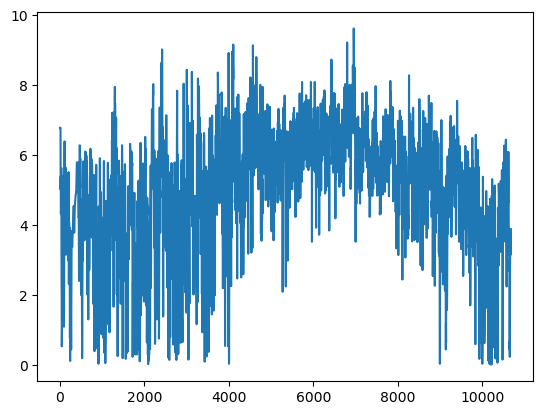

In [4]:
path  = 'data_tibau.csv'
df = pd.read_csv(path, header=None)
v = df.iloc[:,1].values
plt.plot(v)

In [5]:
class Dynamics:
    def __init__(self):
        self.k = 0
        self.Bdt = 755.49
        self.Kdt = 2.7*1e9
        self.Jg = 55*1e6
        self.Jr = 55*1e6    
        self.wr = 1
        self.wg = 1
        self.ot = 0
        self.tau_r = 0
        self.tau_g = 0
        self.uk = 0
        self.RHOv = 1.225 #Air density
        self.Ar = np.pi * 57.5**2 #Rotor area
        self.Rr = 57.5 
        self.Cp_Max = 0.468
        self.lmbd_opt = 7.6
        self.D_hat = 0
        self.Dmax = 1000
        self.rul_ref = 10000
        self.beta = beta_estimator()
        self.beta_ref = (self.Dmax-self.D_hat)/self.rul_ref
        self.ED_t = 1e-16
        self.K1 = 0
        self.K2 = 0

        self.A=np.array([[-self.Bdt/self.Jr, self.Bdt/self.Jr, -self.Kdt/self.Jr],
                         [self.Bdt/self.Jg, -self.Bdt/self.Jg, self.Kdt/self.Jg],
                         [1, -1, 0]])
        self.B = np.array([[1/self.Jr, 0],
                           [0, -1/self.Jg],
                           [0, 0]])
        
    def Lmbd(self,v):
        return self.wr*self.Rr/v
    
    def Lmbd_star(self):
        return self.lmbd_opt+self.uk
    
    def Cp(self,v):
        #print('lamb',self.Lambda(v))
        return (self.Cp_Max*self.Lmbd(v)**3)/(self.lmbd_opt**3)
    
    def Kmppt(self):
        return 0.5*self.RHOv*self.Ar*(self.Rr**3)*self.Cp_Max/(self.lmbd_opt**3)

    def Beta_ref(self):
        beta = (self.Dmax-self.D_hat)/self.rul_ref
        return beta
    
    def Tau_r(self):
        tau_r = 0.5*self.RHOv*self.Ar*self.Cp(v)*(v**3)/(self.wr)
        return tau_r
    
    def Tau_g(self):
        tau_g = self.Kmppt()*(self.wg**2)
        return tau_g
    
    def PD_t(self):
        return self.Bdt((self.wr-self.wg)**2)

    def ED_t_(self):
        self.ED_t = self.ED_t + self.PD_t()

    def PG_t(self):
        return self.tau_g*self.wg



d = Dynamics()

In [8]:
observer = StateObserver(ts=10)
converter = ReferenceConverter()
L_calculado = observer.solve_lmi_gain()

observer.update_state(y_k=1e-16,prnt=True)
D_hat, beta_hat = observer.x_hat
#print(converter.beta_ref, converter.rul_ref)

converter.update(D_hat=D_hat,k=1,prnt=True)
beta_ref = converter.beta_ref
#print(converter.beta_ref, converter.rul_ref)

controller = FeedbackController()
K_calculado = controller.solve_lqr_gain()
#print(controller.u_k,controller.z_k, )
controller.compute_input(beta_hat,beta_ref,prnt=True)
#print(controller.u_k,controller.z_k, )
lmbd_star = controller.lmbd_star

torque_controller = TorqueController()
torque_controller.update(lmbd_star=lmbd_star,wg=1.5,prnt=True)


________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
State Observer parameters:
   ts                                          x_hat                                             L                  H         C
0  10  [0.9288985284746379, -0.00019531640711389063]  [0.08110147152536205, 0.0011953164071138909]  [[1, 10], [0, 1]]  [[1, 0]]
________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Reference Converter parameters:
    rul_ref  D_max  beta_ref
0  999999.0   1000  0.000999
_________________________________________________________________________________________________________________________________